In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as line

import seaborn as sns

import statsmodels as sm

from math import sqrt

from scipy import stats
from scipy.odr import *
from scipy.integrate import odeint
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
xlsx=pd.ExcelFile('COV.xlsx')
data=pd.read_excel(xlsx,'Foglio 1')
data.columns=['Giorno','TOT','NEW','GRW','ACTOT','ACNEW','ACGRW']
data.columns.name='Day'
data.dropna(how='all',inplace=True)
data.drop('Giorno',axis=1,inplace=True)
data.index=range(12,26)
data.drop(12,inplace=True)
data['TOT']= data['TOT']/60000000
data['ACTOT']= data['ACTOT']/60000000
data

Day,TOT,NEW,GRW,ACTOT,ACNEW,ACGRW
13,0.000294,NaN,NaN,0.00024925,NaN,NaN
14,0.000353,3497.0,NaN,0.000295833,2795.0,NaN
15,0.000412,3590.0,1.026594,0.000343383,2853.0,1.020751
16,0.000465,3153.0,0.878273,0.00038455,2470.0,0.865755
17,0.000525,3606.0,1.143673,0.000434367,2989.0,1.210121
18,0.000595,4207.0,1.166667,0.0004785,2648.0,0.885915
19,0.000684,5322.0,1.265034,0.000553167,4480.0,1.691843
20,0.000784,5986.0,1.124765,0.000631,4670.0,1.042411
21,0.000893,6557.0,1.095389,0.00071135,4821.0,1.032334
22,0.000986,5560.0,0.847949,0.0007773,3957.0,0.820784


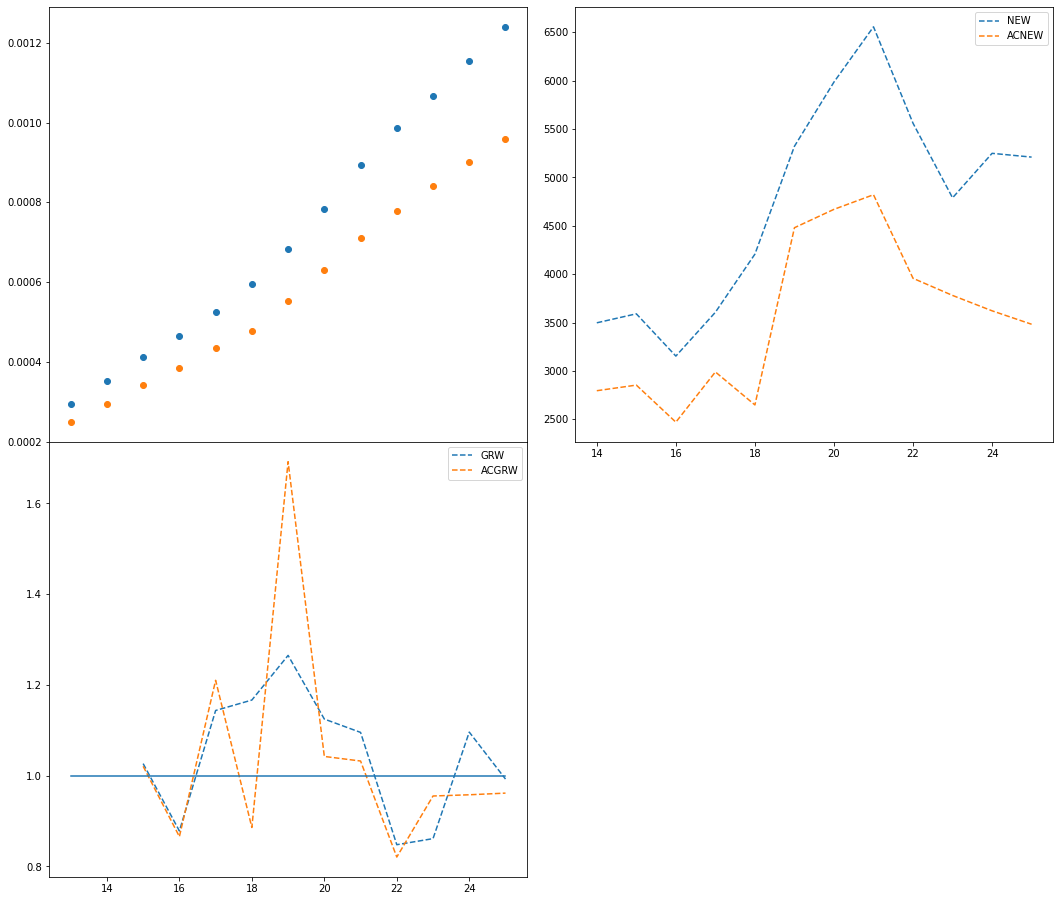

In [3]:
fig=plt.figure(figsize=(18,16))
fig.subplots_adjust(wspace=0.1,hspace=0.1)
tot=fig.add_subplot(2,2,1)
new=fig.add_subplot(2,2,2)
grw=fig.add_subplot(2,2,3)
tot.scatter(data.index,data['TOT'],label='TOT')
tot.scatter(data.index,data['ACTOT'],label='ACTOT')
new.plot(data.index,data['NEW'],'--',label='NEW')
new.plot(data.index,data['ACNEW'],'--',label='ACNEW')
new.legend()
grw.plot(data.index,data['GRW'],'--',label='GRW')
grw.plot(data.index,data['ACGRW'],'--',label='ACGRW')
l = line.Line2D([13,25], [1,1])
grw.add_line(l)
grw.legend()

In [4]:
trans = 2.3 #rateo di trasmissione
recov = 0.6 #rateo di recovery
tmax = 60#numero di giorni fittizio

#initial conditions
sstart = 1-data.loc[13,'TOT']
rstart = 0
istart = data.loc[13,'TOT']
# time points
t = np.linspace(13,13+tmax)
#fit base
def modelI(t,trans,recov):
# function that returns dy/dt
    def model(y,t):
        S=y[0]
        I=y[1]
        R=y[2]
        dS = -trans*S*I
        dI = trans*S*I-recov*I
        dR = recov*I
        return [dS,dI,dR]
    y0=[sstart,istart,rstart]
    # solve ODE
    y = odeint(model,y0,t)
    return y[:,1] 

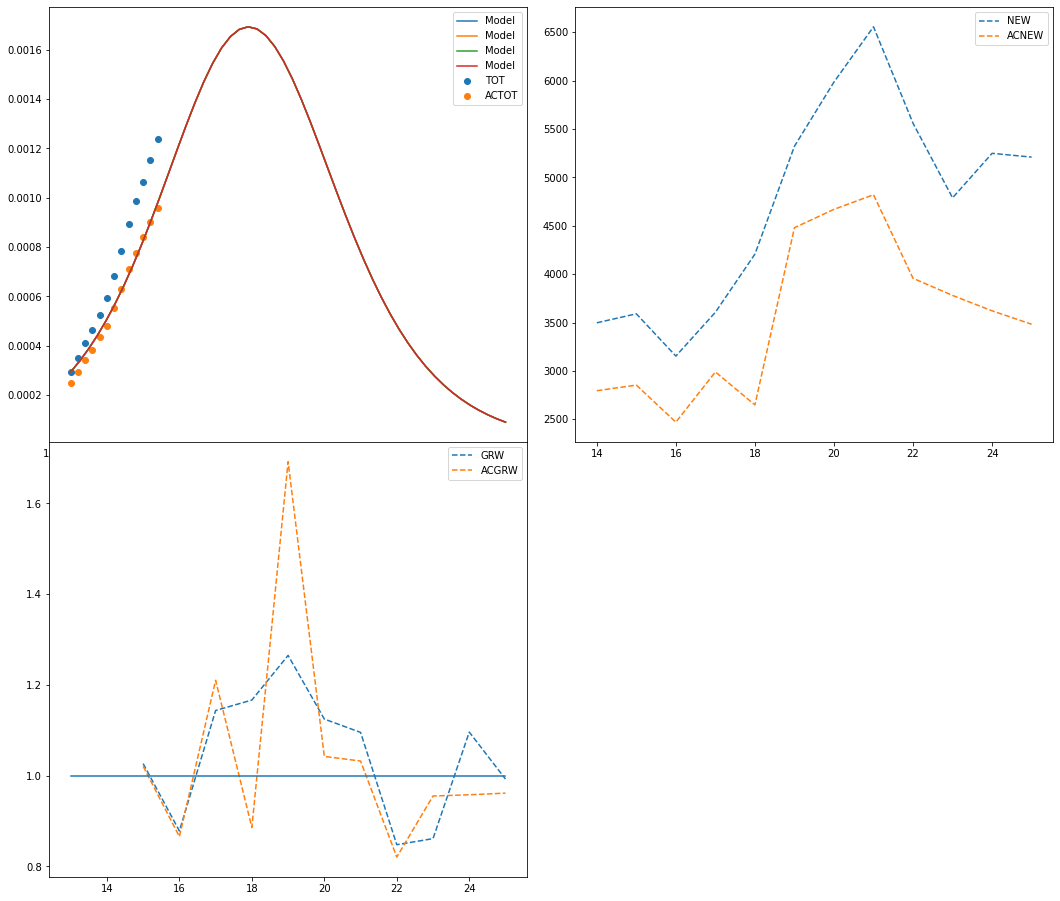

In [8]:
p,cov=curve_fit(modelI,data.index,data['ACTOT'])
trans,recov=p
fit=modelI(t,trans,recov)
tot.plot(t,fit,label='Model')
tot.legend()
fig